# Import libraries

In [21]:
from tensorflow.contrib.keras.python.keras import applications, layers
from tensorflow.contrib.keras.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.contrib.keras.python.keras import optimizers
from tensorflow.contrib.keras.python.keras.models import Sequential, Model
from tensorflow.contrib.keras.python.keras.layers import Dropout, Flatten, Dense, Input, ZeroPadding2D, Conv2D, BatchNormalization, Activation, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.contrib.keras.python.keras.callbacks import EarlyStopping
from tensorflow.contrib.keras.python.keras.optimizers import Adam, RMSprop

from tensorflow.contrib.keras.python.keras.applications.imagenet_utils import _obtain_input_shape
from tensorflow.contrib.keras.python.keras import backend as K

from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

from residual_funcs import *

import numpy as np
import matplotlib.pyplot as plt

# Visualization
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

import pickle

In [2]:
def get_emotion(ohv):
    if ohv.shape[0] == 1:
        indx = ohv[0]
    else:
        indx = np.argmax(ohv)
        
    if indx == 0:
        return 'angry'
    elif indx == 1:
        return 'disgust'
    elif indx == 2:
        return 'fear'
    elif indx == 3:
        return 'happy'
    elif indx == 4:
        return 'sad'
    elif indx == 5:
        return 'surprise'
    elif indx == 6:
        return 'neutral'

# CNN

In [3]:
def CNN():
    base_model = Sequential()

    base_model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape = (48, 48, 1)))

    base_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))

    base_model.add(MaxPooling2D(pool_size=(2, 2)))
    base_model.add(Dropout(0.2))

    base_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))

    base_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    
    base_model.add(MaxPooling2D(pool_size=(2, 2)))
    base_model.add(Dropout(0.2))

    base_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    
    base_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    
    base_model.add(MaxPooling2D(pool_size=(2, 2)))
    base_model.add(Dropout(0.2))

    base_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    
    base_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))

    base_model.add(MaxPooling2D(pool_size=(2, 2)))
    base_model.add(Dropout(0.2))
    
    base_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    
    base_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))

    base_model.add(MaxPooling2D(pool_size=(2, 2)))
    base_model.add(Dropout(0.2))

    base_model.add(Flatten())
    
    return base_model.output, base_model.input, base_model

# FC layer

In [4]:
# add a global spatial average pooling layer
out, inp, base_model = CNN()

out

<tf.Tensor 'flatten_1/Reshape:0' shape=(?, 256) dtype=float32>

In [5]:
# let's add 2 fully-connected layers
x = Dense(512, activation='relu')(out)
x = Dropout(0.2)(x)
# Softmax classifier
predictions = Dense(7, activation='softmax')(x)

In [6]:
# this is the model we will train
model = Model(inputs=inp, outputs=predictions)

In [7]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 128)       147584    
__________

# Compile model

In [8]:
# compile the model (should be done *after* setting layers to non-trainable)
opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit model

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=50)

# train_path = 'E:/EmotiW2017/Train_AFEW/face_images'
# val_path = 'E:/EmotiW2017/Val_AFEW/face_images'

train_path = './data/fer2013/train'
val_path = './data/fer2013/test1'

# fer2013 ------------------------------------------------
train_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(48, 48),
    batch_size=128,
    class_mode='sparse',
    color_mode='grayscale')

# classes=['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

val_datagen = ImageDataGenerator()
val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(48, 48),
    batch_size=97,
    class_mode='sparse',
    color_mode='grayscale')

history = model.fit_generator(generator=train_generator, steps_per_epoch=323,
                    epochs=200, verbose=1, callbacks=[early_stopping],
                    validation_data=val_generator, validation_steps=37)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Epoch 1/200
323/323 [==============================] - 36s - loss: 1.8310 - acc: 0.2439 - val_loss: 1.8418 - val_acc: 0.2494
Epoch 2/200
323/323 [==============================] - 30s - loss: 1.7761 - acc: 0.2686 - val_loss: 1.6246 - val_acc: 0.3558
Epoch 3/200
323/323 [==============================] - 28s - loss: 1.5384 - acc: 0.3981 - val_loss: 1.4345 - val_acc: 0.4550
Epoch 4/200
323/323 [==============================] - 27s - loss: 1.3855 - acc: 0.4660 - val_loss: 1.3022 - val_acc: 0.4999
Epoch 5/200
323/323 [==============================] - 27s - loss: 1.2865 - acc: 0.5087 - val_loss: 1.2172 - val_acc: 0.5300
Epoch 6/200
323/323 [==============================] - 25s - loss: 1.2031 - acc: 0.5442 - val_loss: 1.1989 - val_acc: 0.5469
Epoch 7/200
323/323 [==============================] - 25s - loss: 1.1451 - acc: 0.5659 - val_loss: 1.1385 - val_acc: 0.5737
Epoch 8/200
323/323 [===================

In [10]:
val_path_afew = 'E:/EmotiW2017/Val_AFEW/face_images'
# val_path_afew = './data/fer2013/test1'
# val_path_afew = './data/fer2013/test2'

# AFEW17 ------------------------------------------------
val_datagen_afew = ImageDataGenerator()
val_generator_afew = val_datagen_afew.flow_from_directory(
    val_path_afew,
    target_size=(48, 48),
    batch_size=1,
    class_mode='sparse',
    color_mode='grayscale')

# model.evaluate_generator(generator=val_generator_afew, steps=372)
model.evaluate_generator(generator=val_generator_afew, steps=3589)

Found 372 images belonging to 7 classes.


[3.5917786239506793, 0.32543884090275843]

In [11]:
model.save_weights('fer2013_simple_128_out_testing_1.h5')
base_model.save_weights('fer2013_simple_128_out_testing_nontop_1.h5')

In [12]:
model.load_weights('fer2013_simple_128_out_testing_1.h5')

In [13]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 128)       147584    
__________

In [18]:
base_model.load_weights('fer2013_simple_128_out_testing_nontop_1.h5')

In [19]:
print(base_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 128)       0         
__________

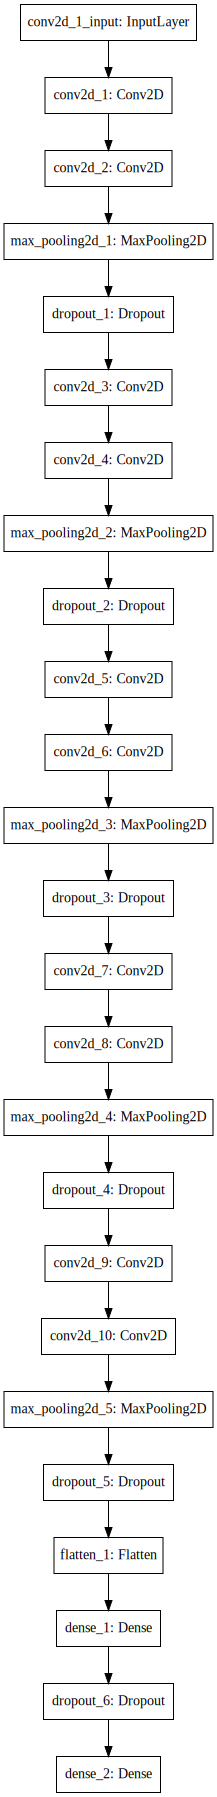

In [14]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))
# plot_model(model, to_file='model.png')

In [25]:
his_path = 'fer2013_simple_128_out_testing_1.pickle'

with open(his_path, 'wb') as f:
    pickle.dump(history.history, f)

dict_keys(['val_acc', 'acc', 'loss', 'val_loss'])


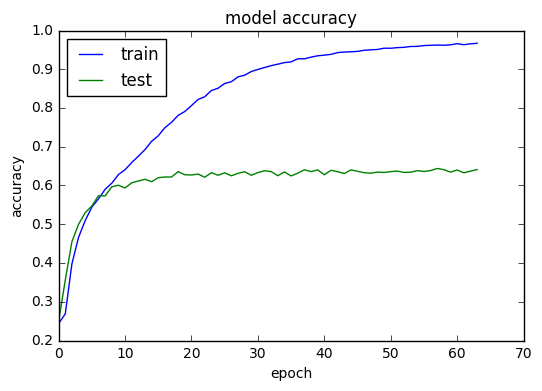

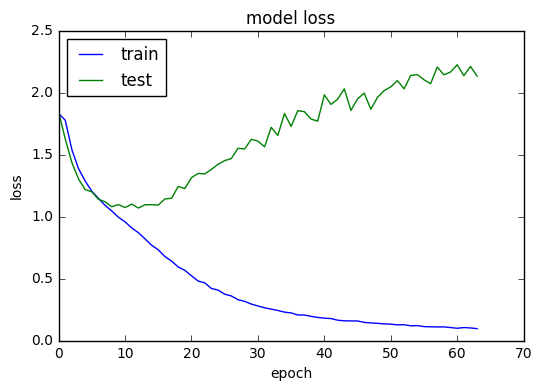

In [23]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [27]:
file = open(his_path,'rb')
history_ = pickle.load(file)

dict_keys(['val_acc', 'acc', 'loss', 'val_loss'])


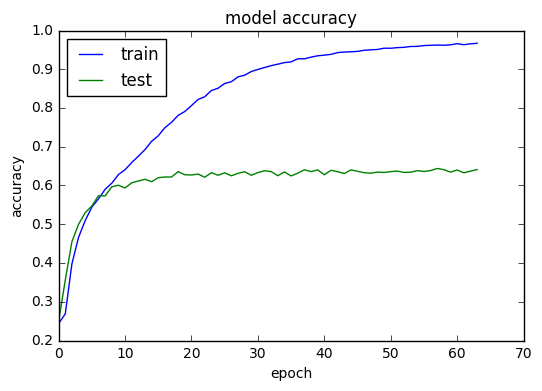

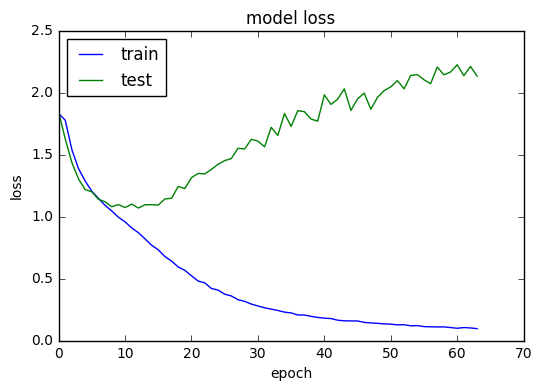

In [29]:
# list all data in history
print(history_.keys())
# summarize history for accuracy
plt.plot(history_['acc'])
plt.plot(history_['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_['loss'])
plt.plot(history_['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()